In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import keras

In [4]:
def load_img(img_dir, img_list):
    images = []
    for i, image_name in enumerate(img_list):
        if (image_name.split('.')[1] == 'npy'):
            image = np.load(img_dir + image_name)
            images.append(image)
    images = np.array(images)
    return (images)


In [5]:
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):
    L = len(img_list)

    # keras needs the generator infinite, so we will use while true
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X, Y)  # a tuple with two numpy arrays with batch_size samples

            batch_start += batch_size
            batch_end += batch_size

In [6]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU

In [7]:
kernel_initializer = 'he_uniform'


def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    # s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    # Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    # Expansive path
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [8]:
model = simple_unet_model(128, 128, 128, 3, 4)
print(model.input_shape)
print(model.output_shape)

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


In [9]:
train_img_dir = '/content/drive/MyDrive/Data/Split/train/data/'
train_mask_dir = '/content/drive/MyDrive/Data/Split/train/mask/'

val_img_dir = '/content/drive/MyDrive/Data/Split/val/data/'
val_mask_dir = '/content/drive/MyDrive/Data/Split/val/mask/'

In [10]:
train_img_list = os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list = os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

In [11]:
batch_size = 2

In [12]:
train_img_datagen = imageLoader(train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, val_mask_dir, val_mask_list, batch_size)

In [12]:
!pip uninstall keras -y

Found existing installation: keras 2.15.0
Uninstalling keras-2.15.0:
  Successfully uninstalled keras-2.15.0


In [13]:
!pip install keras==3.3.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 41.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [13]:
import keras
print(keras.__version__)

3.3.3


In [1]:
!pip install segmentation_models_3D
import segmentation_models_3D as sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 5.5 MB/s eta 0:00:00
Segmentation Models: using `keras` framework.


In [14]:
sm.__version__

'1.0.6'

In [15]:
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [17]:
import tensorflow as tf

def my_iou_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true + y_pred) - intersection
    smooth = 1.0  # You can adjust this smoothing factor

    return tf.reduce_mean((intersection + smooth) / (union + smooth))



metrics = [my_iou_score, 'accuracy']


# metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = keras.optimizers.Adam(LR)

In [18]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

In [19]:
print(steps_per_epoch, val_steps_per_epoch)

137 34


In [20]:
model = simple_unet_model(IMG_HEIGHT=128, IMG_WIDTH=128, IMG_DEPTH=128, IMG_CHANNELS=3, num_classes=4)

In [21]:
model.compile(optimizer = optim, loss=total_loss, metrics = metrics)

In [22]:
print(model.summary())

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 128,  │              0 │ -                      │
│ (InputLayer)              │ 3)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_19 (Conv3D)        │ (None, 128, 128, 128,  │          1,312 │ input_layer_1[0][0]    │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 128, 128, 128,  │              0 │ conv3d_19[0][0]        │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_20 (Conv3D)        │ (None, 128, 128, 128,  │          6,928 │ dropout_9[0][0]        │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_4           │ (None, 64, 64, 64, 16) │              0 │ conv3d_20[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_21 (Conv3D)        │ (None, 64, 64, 64, 32) │         13,856 │ max_pooling3d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 64, 64, 64, 32) │              0 │ conv3d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_22 (Conv3D)        │ (None, 64, 64, 64, 32) │         27,680 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_5           │ (None, 32, 32, 32, 32) │              0 │ conv3d_22[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_23 (Conv3D)        │ (None, 32, 32, 32, 64) │         55,360 │ max_pooling3d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 32, 32, 32, 64) │              0 │ conv3d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_24 (Conv3D)        │ (None, 32, 32, 32, 64) │        110,656 │ dropout_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d_6           │ (None, 16, 16, 16, 64) │              0 │ conv3d_24[0][0]        │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_25 (Conv3D)        │ (None, 16, 16, 16,     │        221,312 │ max_pooling3d_6[0][0]  │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 16, 16, 16,     │              0 │ conv3d_25[0][0]        │
│                           │ 128)                   │                │                        │
├──────────────────────

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

None


In [23]:
print(model.input_shape)
print(model.output_shape)

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


In [ ]:
history=model.fit(train_img_datagen, steps_per_epoch = steps_per_epoch, epochs=100, verbose = 1, validation_data = val_img_datagen, validation_steps = val_steps_per_epoch)

model.save('brats_3d.hdf5')

Epoch 1/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 831s 5s/step - accuracy: 0.8065 - loss: 0.9728 - my_iou_score: 0.4829 - val_accuracy: 0.9487 - val_loss: 0.9442 - val_my_iou_score: 0.6559
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 643s 5s/step - accuracy: 0.9515 - loss: 0.9412 - my_iou_score: 0.7340 - val_accuracy: 0.9487 - val_loss: 0.9436 - val_my_iou_score: 0.6229
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 627s 5s/step - accuracy: 0.9515 - loss: 0.9403 - my_iou_score: 0.7404 - val_accuracy: 0.9492 - val_loss: 0.9431 - val_my_iou_score: 0.6338
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 608s 4s/step - accuracy: 0.9515 - loss: 0.9398 - my_iou_score: 0.7448 - val_accuracy: 0.9487 - val_loss: 0.9422 - val_my_iou_score: 0.6510
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 584s 4s/step - accuracy: 0.9515 - loss: 0.9395 - my_iou_score: 0.7481 - val_accuracy: 0.9498 - val_loss: 0.9420 - val_my_iou_score: 0.6505
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 513s 4s/step - accuracy: 0.9515 - loss: 0.9392 - my_iou_sco

7.npy 7.npy


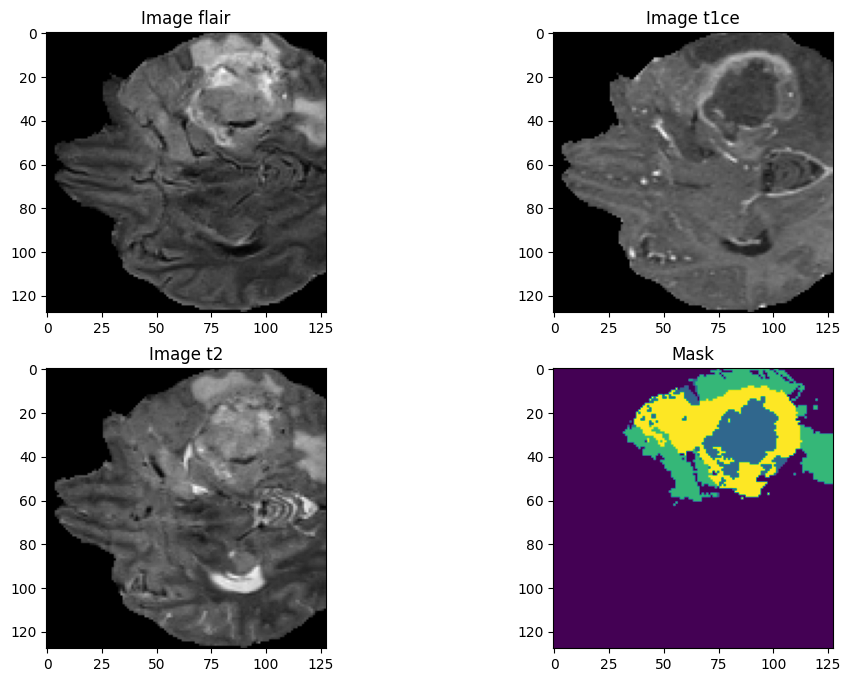

In [ ]:
# import random

# img_num = random.randint(0,num_images-1)
# test_img = np.load(train_img_dir+img_list[img_num])
# test_mask = np.load(train_mask_dir+mask_list[img_num])
# test_mask = np.argmax(test_mask, axis=3)

# print(img_list[img_num], mask_list[img_num])

# n_slice=random.randint(0, test_mask.shape[2])
# plt.figure(figsize=(12, 8))

# plt.subplot(221)
# plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
# plt.title('Image flair')
# plt.subplot(222)
# plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
# plt.title('Image t1ce')
# plt.subplot(223)
# plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
# plt.title('Image t2')
# plt.subplot(224)
# plt.imshow(test_mask[:,:,n_slice])
# plt.title('Mask')
# plt.show()